In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load data
purchase_behavior_path = "QVI_purchase_behaviour.csv"
transaction_data_path = "QVI_transaction_data.xlsx"

purchase_df = pd.read_csv(purchase_behavior_path)
transaction_df = pd.read_excel(transaction_data_path, sheet_name='in')

# Convert date format
transaction_df['DATE'] = pd.to_datetime(transaction_df['DATE'], origin='1899-12-30', unit='D')
# Filter out salsa products
transaction_df1 = transaction_df[~transaction_df['PROD_NAME'].str.contains("salsa", case=False, na=False)]
# print("Remaining product categories:\n", transaction_df1['PROD_NAME'].unique())

# Filter transactions where product quantity is 200
outlier_transactions = transaction_df1[transaction_df1['PROD_QTY'] == 200]

# Display the outlier transactions
# print(outlier_transactions)

# Identify the customer ID from the outlier transactions
outlier_customer = outlier_transactions['LYLTY_CARD_NBR'].iloc[0]

# Remove this customer from the dataset
cleaned_df = transaction_df1[transaction_df1['LYLTY_CARD_NBR'] != outlier_customer]

<ipython-input-5-4e30c8022db9>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_transaction_data['TRANSACTION_COUNT'].fillna(0, inplace=True)


Missing Dates: [Timestamp('2018-12-25 00:00:00')]


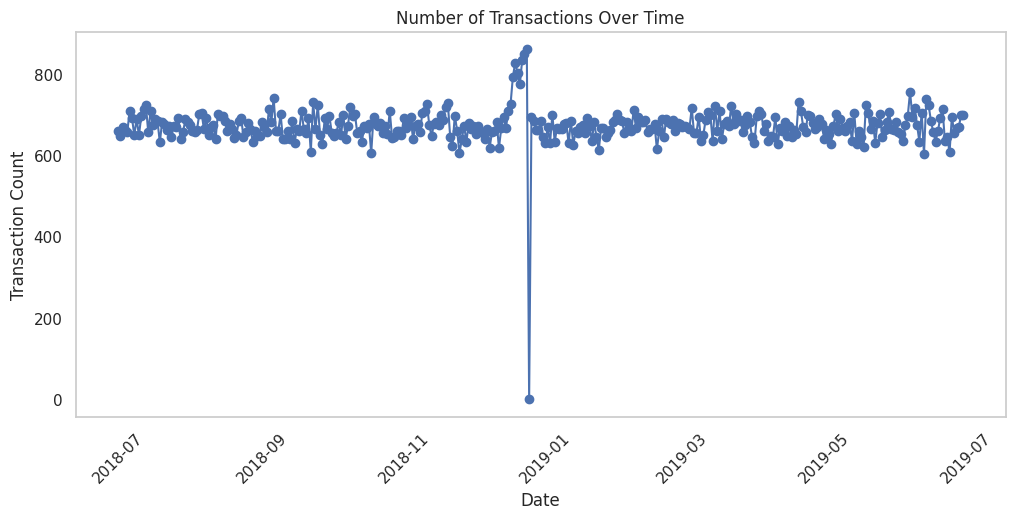

In [5]:
# Group by transaction date and count the number of transactions per day
transaction_summary = cleaned_df.groupby('DATE')['TXN_ID'].nunique().reset_index()
# Rename columns for clarity
transaction_summary.columns = ['DATE', 'TRANSACTION_COUNT']

# Display the first few rows
# print(transaction_summary.head())

# Generate a full date sequence from 1 July 2018 to 30 June 2019
full_date_range = pd.DataFrame({'DATE': pd.date_range(start='2018-07-01', end='2019-06-30')})

# Merge with the full date range to find missing dates
full_transaction_data = full_date_range.merge(transaction_summary, on='DATE', how='left')

# Fill missing transaction counts with 0
full_transaction_data['TRANSACTION_COUNT'].fillna(0, inplace=True)

# Identify missing dates
missing_dates = full_transaction_data[full_transaction_data['TRANSACTION_COUNT'] == 0]['DATE']
print("Missing Dates:", missing_dates.tolist())

sns.set_theme(style="whitegrid")

# Plot transaction count over time
plt.figure(figsize=(12,5))
plt.plot(full_transaction_data['DATE'], full_transaction_data['TRANSACTION_COUNT'], marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Transaction Count")
plt.title("Number of Transactions Over Time")
plt.xticks(rotation=45)
plt.grid()
plt.show()


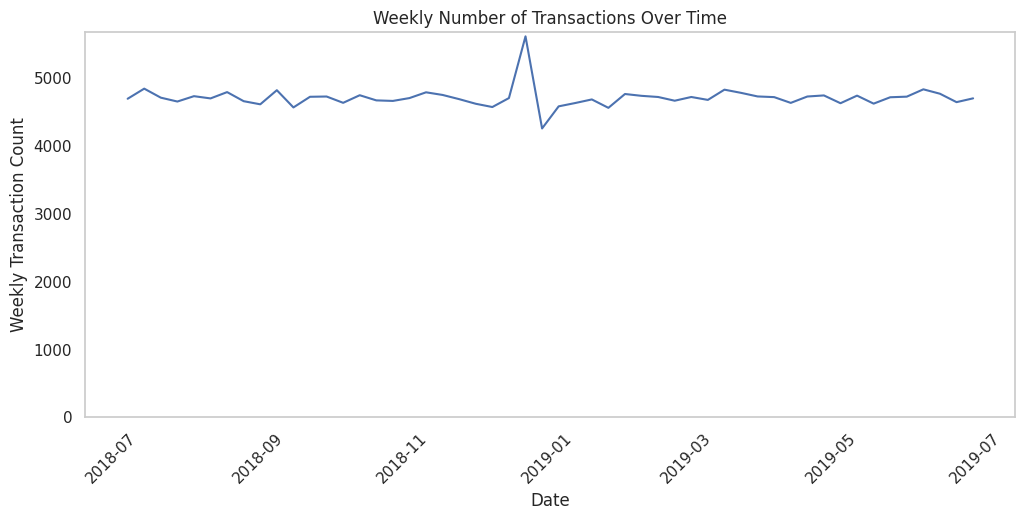

In [6]:
# Resample to weekly frequency and sum transactions
weekly_transactions = full_transaction_data.resample('W', on='DATE')['TRANSACTION_COUNT'].sum().reset_index()

# Remove the first data point (starting point)
weekly_transactions = weekly_transactions[1:]

# Plotting the weekly transaction count
plt.figure(figsize=(12, 5))
plt.plot(weekly_transactions['DATE'], weekly_transactions['TRANSACTION_COUNT'])
plt.xlabel("Date")
plt.ylabel("Weekly Transaction Count")
plt.title("Weekly Number of Transactions Over Time")
plt.xticks(rotation=45)
plt.grid()
plt.ylim(bottom=0)
plt.show()

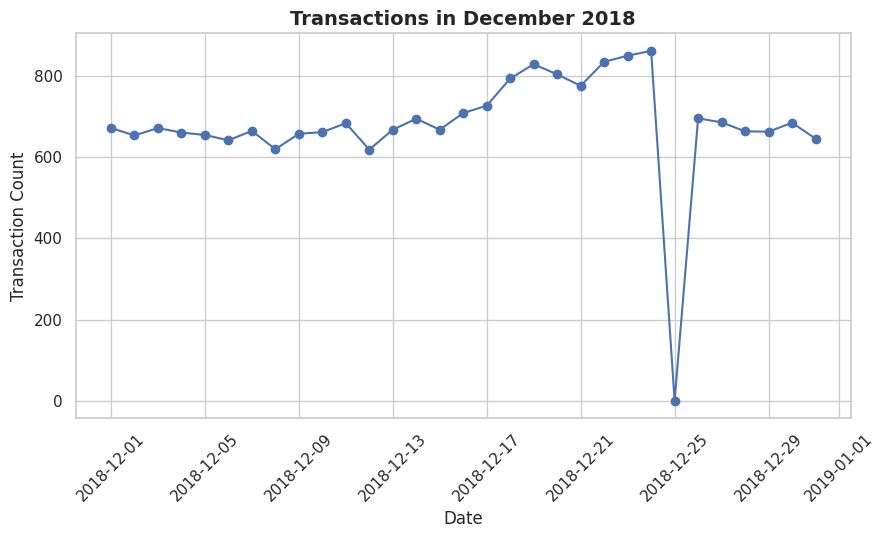

In [7]:
# Filter data for December 2018
december_data = full_transaction_data[
    (full_transaction_data['DATE'] >= '2018-12-01') & (full_transaction_data['DATE'] <= '2018-12-31')
]
# Plot December transactions
plt.figure(figsize=(10,5))
plt.plot(december_data['DATE'], december_data['TRANSACTION_COUNT'], marker='o', linestyle='-')

# Formatting the plot
plt.xlabel("Date", fontsize=12)
plt.ylabel("Transaction Count", fontsize=12)
plt.title("Transactions in December 2018", fontsize=14, fontweight='bold', loc='center')
plt.xticks(rotation=45)
plt.grid(True)

We can see that the increase in sales occurs in the lead-up to Christmas and that there are zero sales on Christmas day itself. This is due to shops being closed on Christmas day.

In [8]:
# Extract pack size and brand name
def extract_pack_size(prod_name):
    prod_name=prod_name.lower()
    size = re.findall(r'\d{2,4}g', prod_name)
    return int(size[0][:-1]) if size else np.nan

def extract_brand(prod_name):
    return prod_name.split()[0]

cleaned_df['PACK_SIZE'] = cleaned_df['PROD_NAME'].apply(extract_pack_size)
cleaned_df['BRAND'] = cleaned_df['PROD_NAME'].apply(extract_brand)

# Merge transaction data with purchase behavior data
merged_df = cleaned_df.merge(purchase_df, on='LYLTY_CARD_NBR', how='left')

# Summary statistics
print("Missing values:")
print(merged_df.isnull().sum())

merged_df.loc[merged_df['BRAND'] == 'RRD', 'BRAND'] = 'RED'
merged_df.loc[merged_df['BRAND'] == 'Red', 'BRAND'] = 'RED'
merged_df.loc[merged_df['BRAND'] == 'Infzns', 'BRAND'] = 'Infuzions'
merged_df.loc[merged_df['BRAND'] == 'WW', 'BRAND'] = 'Woolworths'
merged_df.loc[merged_df['BRAND'] == 'Smith', 'BRAND'] = 'Smiths'
merged_df.loc[merged_df['BRAND'] == 'Doritos', 'BRAND'] = 'Dorito'
merged_df.loc[merged_df['BRAND'] == 'NCC', 'BRAND'] = 'CCs'
merged_df.loc[merged_df['BRAND'] == 'Snbts', 'BRAND'] = 'Sunbites'
# print(set(merged_df['BRAND']))

# Save cleaned data
merged_df.to_csv('cleaned_transaction_data.csv', index=False)

<ipython-input-8-246d7bbb5eff>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['PACK_SIZE'] = cleaned_df['PROD_NAME'].apply(extract_pack_size)
<ipython-input-8-246d7bbb5eff>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['BRAND'] = cleaned_df['PROD_NAME'].apply(extract_brand)


Missing values:
DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64


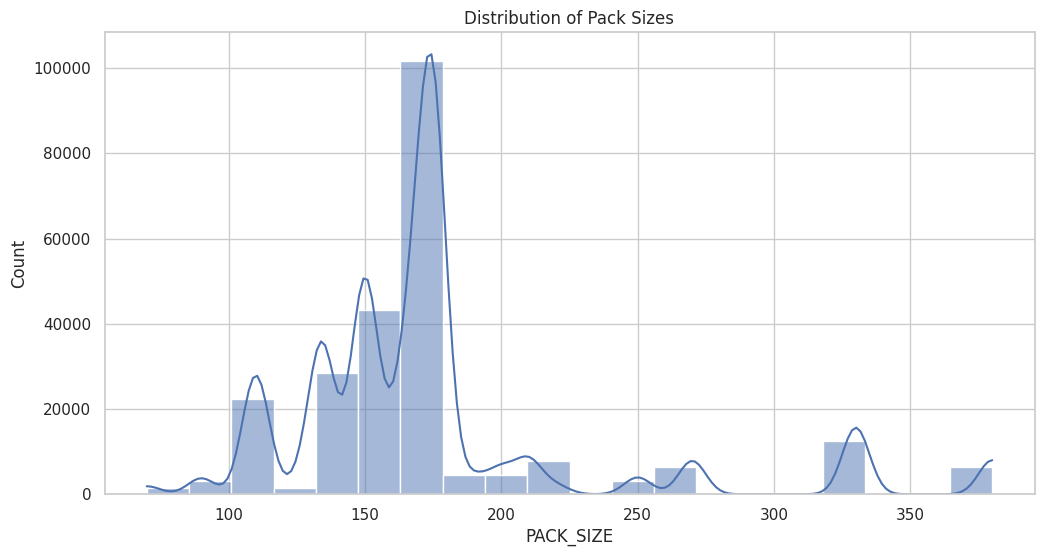

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(merged_df['PACK_SIZE'], bins=20, kde=True)
plt.title('Distribution of Pack Sizes')
plt.show()

In [9]:
# Grouping by customer segments (LIFESTAGE and PREMIUM_CUSTOMER) to calculate total revenue
segment_revenue = merged_df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()

# Calculating the total revenue
total_revenue = segment_revenue['TOT_SALES'].sum()

# Adding a Revenue Contribution column
segment_revenue['Revenue Contribution (%)'] = (segment_revenue['TOT_SALES'] / total_revenue) * 100

# Displaying the result
segment_revenue[['LIFESTAGE', 'PREMIUM_CUSTOMER', 'Revenue Contribution (%)']]


,LIFESTAGE,PREMIUM_CUSTOMER,Revenue Contribution (%)
0,MIDAGE SINGLES/COUPLES,Budget,1.847225
1,MIDAGE SINGLES/COUPLES,Mainstream,4.693956
2,MIDAGE SINGLES/COUPLES,Premium,3.015983
3,NEW FAMILIES,Budget,1.141575
4,NEW FAMILIES,Mainstream,0.885215
5,NEW FAMILIES,Premium,0.596108
6,OLDER FAMILIES,Budget,8.689657
7,OLDER FAMILIES,Mainstream,5.340945
8,OLDER FAMILIES,Premium,4.168155
9,OLDER SINGLES/COUPLES,Budget,7.081497


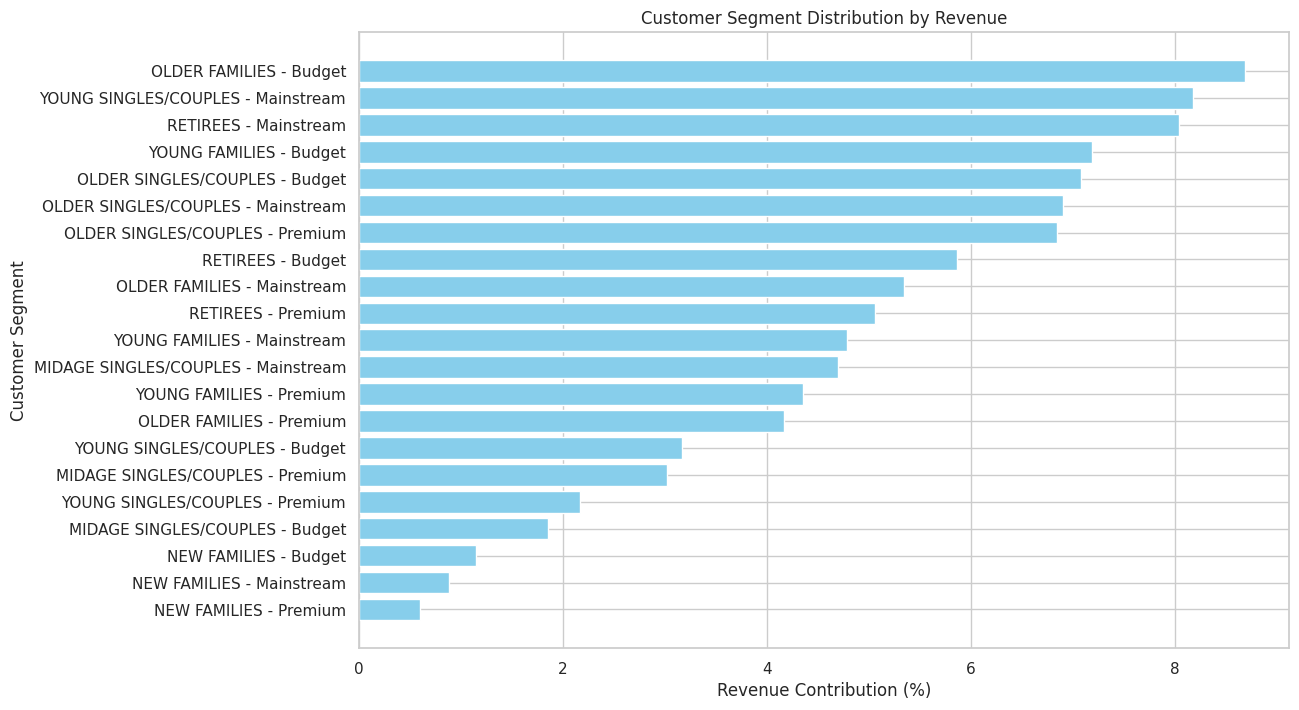

In [10]:
# Combining LIFESTAGE and PREMIUM_CUSTOMER for clear labels
segment_revenue['Segment'] = segment_revenue['LIFESTAGE'] + ' - ' + segment_revenue['PREMIUM_CUSTOMER']

# Sorting by revenue contribution for better visualization
segment_revenue = segment_revenue.sort_values(by='Revenue Contribution (%)', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(12, 8))
plt.barh(segment_revenue['Segment'], segment_revenue['Revenue Contribution (%)'], color='skyblue')
plt.xlabel('Revenue Contribution (%)')
plt.ylabel('Customer Segment')
plt.title('Customer Segment Distribution by Revenue')
plt.gca().invert_yaxis()  # Invert y-axis to display highest contribution at the top



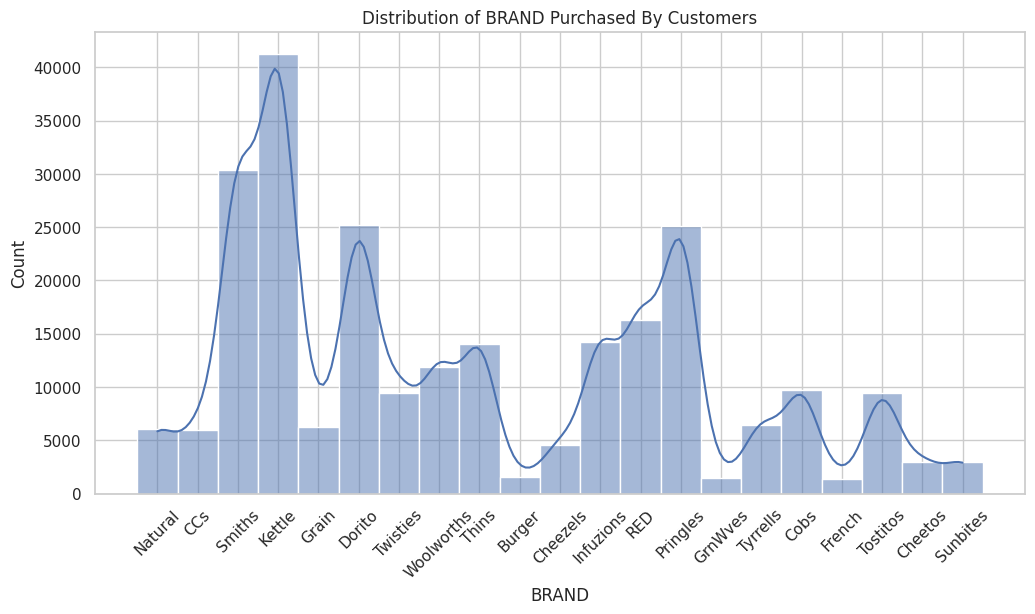

In [11]:
plt.figure(figsize=(12, 6))
sns.histplot(merged_df['BRAND'], bins=20, kde=True)
plt.title('Distribution of BRAND Purchased By Customers')
plt.xticks(rotation=45)
plt.show()


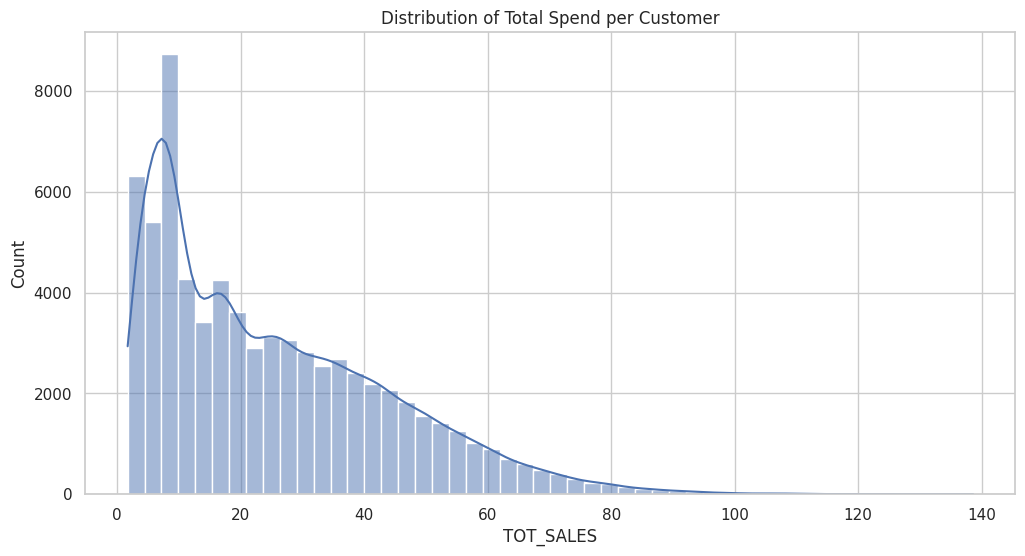

In [12]:
# Total spend per customer
customer_spend = merged_df.groupby('LYLTY_CARD_NBR')['TOT_SALES'].sum().reset_index()

# Purchase frequency per customer
customer_freq = merged_df.groupby('LYLTY_CARD_NBR')['TXN_ID'].count().reset_index()
customer_freq.columns = ['LYLTY_CARD_NBR', 'PURCHASE_FREQUENCY']

# Merge spend and frequency data
customer_summary = customer_spend.merge(customer_freq, on='LYLTY_CARD_NBR')

# Visualizations
plt.figure(figsize=(12, 6))
sns.histplot(customer_summary['TOT_SALES'], bins=50, kde=True)
plt.title('Distribution of Total Spend per Customer')
plt.show()


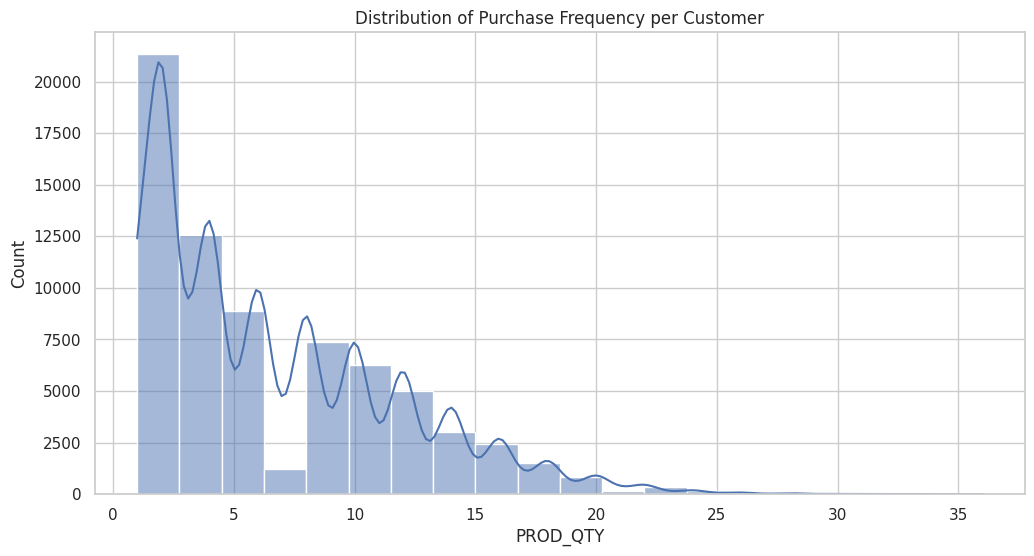

In [13]:
# Total Quantity Purchased  per customer
customer_quantity = merged_df.groupby('LYLTY_CARD_NBR')['PROD_QTY'].sum().reset_index()

customer_summary2 = customer_summary.merge(customer_quantity, on='LYLTY_CARD_NBR')

plt.figure(figsize=(12, 6))
sns.histplot(customer_summary2['PROD_QTY'], bins=20, kde=True)
plt.title('Distribution of Purchase Frequency per Customer')
plt.show()

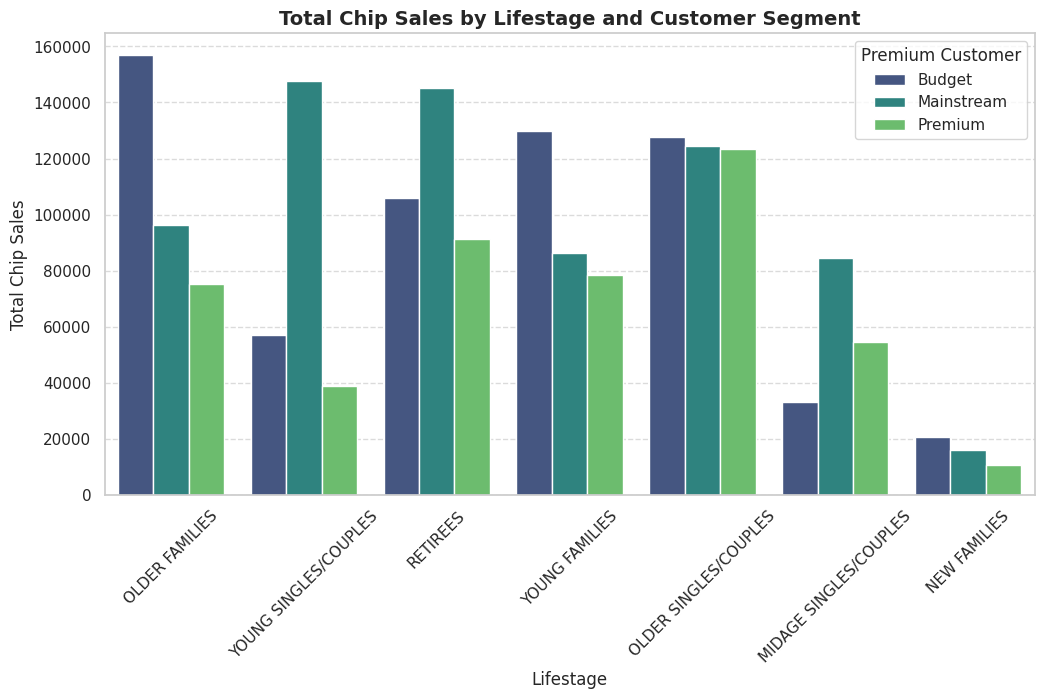

In [14]:
# Group by LIFESTAGE and PREMIUM_CUSTOMER, summing total sales
sales_by_segment = merged_df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()

# Sort values for better visualization
sales_by_segment = sales_by_segment.sort_values(by='TOT_SALES', ascending=False)

# Plot sales by customer segment
plt.figure(figsize=(12, 6))
sns.barplot(data=sales_by_segment, x='LIFESTAGE', y='TOT_SALES', hue='PREMIUM_CUSTOMER', palette='viridis')

# Formatting the plot
plt.xlabel("Lifestage", fontsize=12)
plt.ylabel("Total Chip Sales", fontsize=12)
plt.title("Total Chip Sales by Lifestage and Customer Segment", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.legend(title="Premium Customer", loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


Sales are coming mainly from Budget - older families, Mainstream - young singles/couples, and Mainstream - retirees

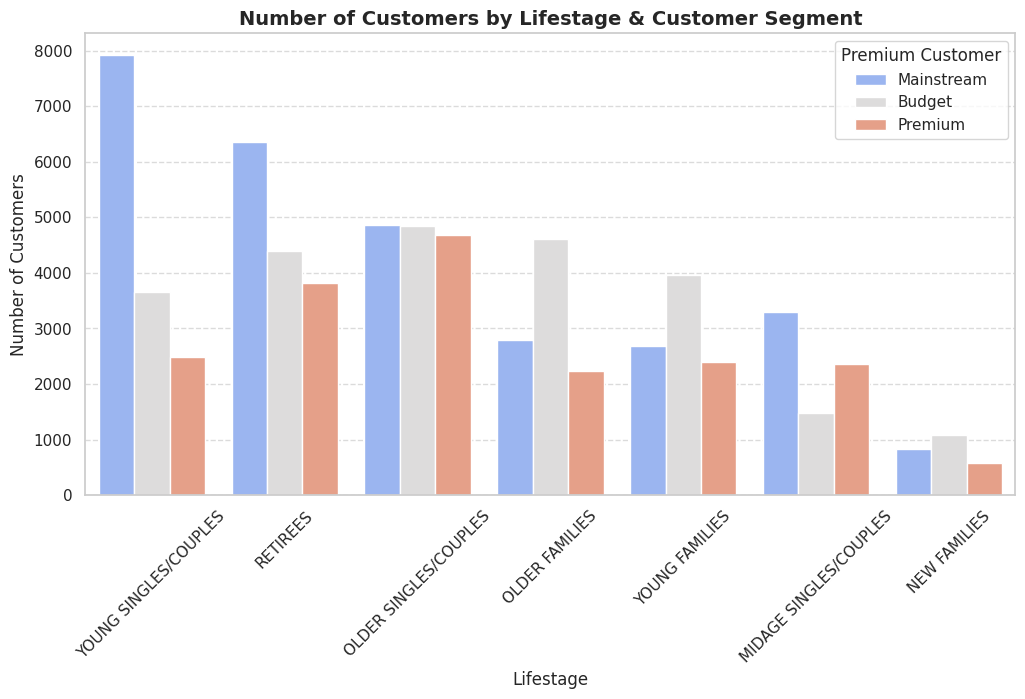

In [15]:
# Number of Customers in Each Segment

customers_by_segment = merged_df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().reset_index()

# Rename column
customers_by_segment.columns = ['LIFESTAGE', 'PREMIUM_CUSTOMER', 'CUSTOMER_COUNT']

# sorting
customers_by_segment = customers_by_segment.sort_values(by='CUSTOMER_COUNT', ascending=False)

# Plot customer distribution by segment
plt.figure(figsize=(12, 6))
sns.barplot(data=customers_by_segment, x='LIFESTAGE', y='CUSTOMER_COUNT', hue='PREMIUM_CUSTOMER', palette='coolwarm')

# Formatting the plot
plt.xlabel("Lifestage", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.title("Number of Customers by Lifestage & Customer Segment", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.legend(title="Premium Customer", loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

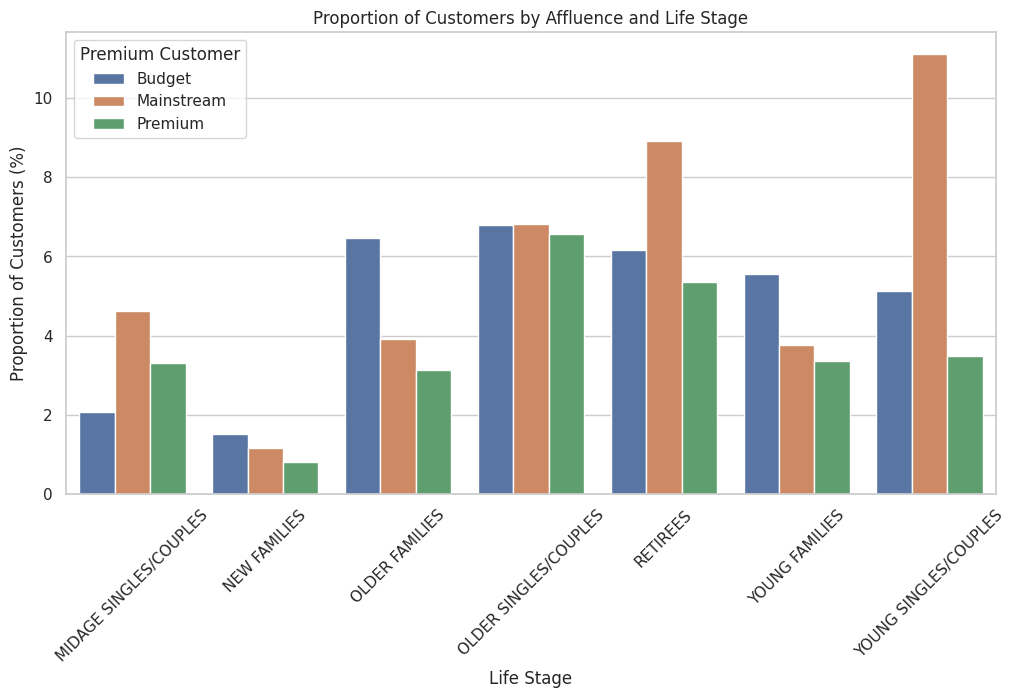

In [16]:
# Calculate the proportion of customers in each segment
customer_segment_counts = merged_df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().reset_index()
customer_segment_counts.rename(columns={'LYLTY_CARD_NBR': 'Customer Count'}, inplace=True)
total_customers = customer_segment_counts['Customer Count'].sum()
customer_segment_counts['Proportion'] = (customer_segment_counts['Customer Count'] / total_customers) * 100

# Create a plot to visualize the proportion of customers by affluence and life stage
plt.figure(figsize=(12, 6))
sns.barplot(data=customer_segment_counts, x='LIFESTAGE', y='Proportion', hue='PREMIUM_CUSTOMER')
plt.title('Proportion of Customers by Affluence and Life Stage')
plt.xlabel('Life Stage')
plt.ylabel('Proportion of Customers (%)')
plt.xticks(rotation=45)
plt.legend(title='Premium Customer')
plt.show()


There are more Mainstream - young singles/couples and Mainstream - retirees who buy chips. This contributes to there being more sales to these customer segments but this is not a major driver for the Budget - Older families segment.

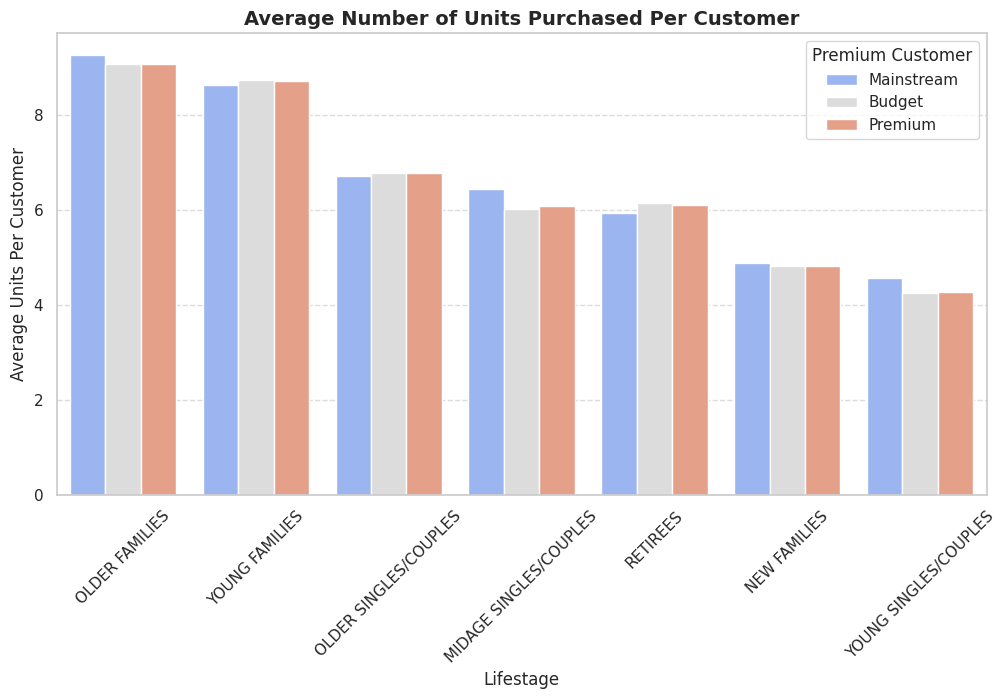

In [17]:
# Chips Bought per Customer by Segment
chips_per_customer = merged_df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].sum().reset_index()

# Merge with customer count
chips_per_customer = chips_per_customer.merge(customers_by_segment, on=['LIFESTAGE', 'PREMIUM_CUSTOMER'])
chips_per_customer['AVG_CHIPS_PER_CUSTOMER'] = chips_per_customer['PROD_QTY'] / chips_per_customer['CUSTOMER_COUNT']

# Display
chips_per_customer = chips_per_customer[['LIFESTAGE', 'PREMIUM_CUSTOMER', 'AVG_CHIPS_PER_CUSTOMER']].sort_values(by='AVG_CHIPS_PER_CUSTOMER', ascending=False)

# Plot customer distribution by segment
plt.figure(figsize=(12, 6))
sns.barplot(data=chips_per_customer, x='LIFESTAGE', y='AVG_CHIPS_PER_CUSTOMER', hue='PREMIUM_CUSTOMER', palette='coolwarm')

# Formatting the plot
plt.xlabel("Lifestage", fontsize=12)
plt.ylabel("Average Units Per Customer", fontsize=12)
plt.title("Average Number of Units Purchased Per Customer", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.legend(title="Premium Customer", loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

Older families and young families in general buy more chips per customer.

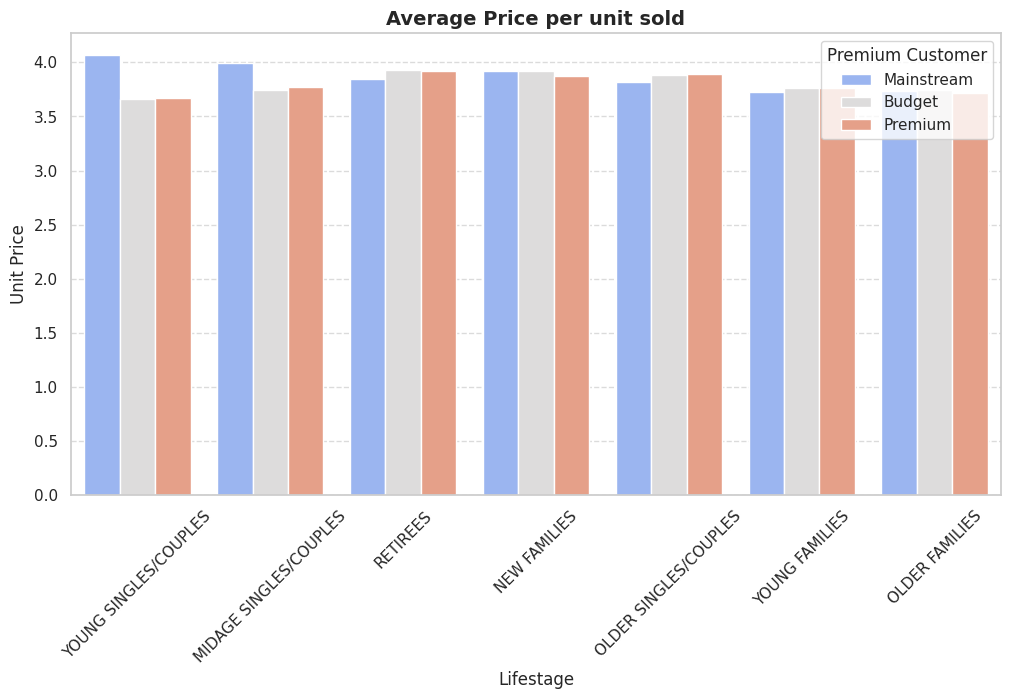

In [18]:
# Average Chip Price by Customer Segment

# Average price per chip packet
merged_df['UNIT_PRICE'] = merged_df['TOT_SALES'] / merged_df['PROD_QTY']

avg_price_by_segment = merged_df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['UNIT_PRICE'].mean().reset_index()

# sorting
avg_price_by_segment = avg_price_by_segment.sort_values(by='UNIT_PRICE', ascending=False)

# Plot customer distribution by segment
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_price_by_segment, x='LIFESTAGE', y='UNIT_PRICE', hue='PREMIUM_CUSTOMER', palette='coolwarm')

# Formatting the plot
plt.xlabel("Lifestage", fontsize=12)
plt.ylabel("Unit Price", fontsize=12)
plt.title("Average Price per unit sold", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.legend(title="Premium Customer", loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

Mainstream midage and young singles and couples are more willing to pay more per packet of chips compared to their budget and premium counterparts. This may be due to premium shoppers being more likely to buy healthy snacks and when they buy chips, this is mainly for entertainment purposes rather than their own consumption. This is also supported by there being fewer premium midage and young singles and couples buying chips compared to their mainstream counterparts.

In [19]:
import scipy.stats as stats

# 1️ T-test: Mainstream vs. Premium Customers
mainstream_prices = merged_df[merged_df['PREMIUM_CUSTOMER'] == 'Mainstream']['UNIT_PRICE']
premium_prices = merged_df[(merged_df['PREMIUM_CUSTOMER'] == 'Premium') |( merged_df['PREMIUM_CUSTOMER'] == 'Budget')]['UNIT_PRICE']

t_stat1, p_value1 = stats.ttest_ind(mainstream_prices, premium_prices, equal_var=False)
print(f"T-test: Mainstream vs. Premium Customers → t-statistic: {t_stat1:.4f}, p-value: {p_value1:.4f}")

# 2️ T-test: Budget Mid-age vs. Premium Mid-age
budget_midage_prices = merged_df[(merged_df['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') &
                                  (merged_df['PREMIUM_CUSTOMER'] == 'Budget')]['UNIT_PRICE']
premium_midage_prices = merged_df[(merged_df['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') &
                                   (merged_df['PREMIUM_CUSTOMER'] == 'Premium')]['UNIT_PRICE']

t_stat2, p_value2 = stats.ttest_ind(budget_midage_prices, premium_midage_prices, equal_var=False)
print(f"T-test: Mid-age Budget vs. Mid-age Premium → t-statistic: {t_stat2:.4f}, p-value: {p_value2:.4f}")

# 3️ T-test: Young Singles & Couples vs. Other Groups
young_singles_couples_prices = merged_df[merged_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES']['UNIT_PRICE']
other_groups_prices = merged_df[merged_df['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES']['UNIT_PRICE']

t_stat3, p_value3 = stats.ttest_ind(young_singles_couples_prices, other_groups_prices, equal_var=False)
print(f"T-test: Young Singles & Couples vs. Other Groups → t-statistic: {t_stat3:.4f}, p-value: {p_value3:.4f}")



T-test: Mainstream vs. Premium Customers → t-statistic: 15.1186, p-value: 0.0000
T-test: Mid-age Budget vs. Mid-age Premium → t-statistic: -1.3537, p-value: 0.1758
T-test: Young Singles & Couples vs. Other Groups → t-statistic: 2.4763, p-value: 0.0133


In [20]:
# mainstream_prices = merged_df[((merged_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (merged_df['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES')) &
#                               (merged_df['PREMIUM_CUSTOMER'] == 'Mainstream')
#                               ]['UNIT_PRICE']
# premium_prices = merged_df[((merged_df['PREMIUM_CUSTOMER'] == 'Premium') | (merged_df['PREMIUM_CUSTOMER'] == 'Budget')) &
#                            ((merged_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (merged_df['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES'))]['UNIT_PRICE']

mainstream_prices = merged_df[(merged_df['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') &
                              (merged_df['PREMIUM_CUSTOMER'] == 'Mainstream')
                              ]['UNIT_PRICE']
premium_prices = merged_df[((merged_df['PREMIUM_CUSTOMER'] == 'Premium') | (merged_df['PREMIUM_CUSTOMER'] == 'Budget')) &
                           (merged_df['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES')]['UNIT_PRICE']

t_stat4, p_value4 = stats.ttest_ind(mainstream_prices, premium_prices, equal_var=False)
print(f"T-test: mainstream, mid-age vs.  budget or premium, midagex → t-statistic: {t_stat4:.4f}, p-value: {p_value4:.4f}")

mainstream_prices = merged_df[(merged_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &
                              (merged_df['PREMIUM_CUSTOMER'] == 'Mainstream')
                              ]['UNIT_PRICE']
premium_prices = merged_df[((merged_df['PREMIUM_CUSTOMER'] == 'Premium') | (merged_df['PREMIUM_CUSTOMER'] == 'Budget')) &
                           (merged_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES')]['UNIT_PRICE']

t_stat5, p_value5 = stats.ttest_ind(mainstream_prices, premium_prices, equal_var=False)
print(f"T-test: mainstream, young vs.  budget or premium, young → t-statistic: {t_stat5:.4f}, p-value: {p_value5:.4f}")

mainstream_prices = merged_df[(merged_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &
                              (merged_df['PREMIUM_CUSTOMER'] == 'Budget')]['UNIT_PRICE']
premium_prices = merged_df[(merged_df['PREMIUM_CUSTOMER'] == 'Premium')  &
                           (merged_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES')]['UNIT_PRICE']

t_stat6, p_value6 = stats.ttest_ind(mainstream_prices, premium_prices, equal_var=False)
print(f"T-test: Budget, young vs. premium, young → t-statistic: {t_stat6:.4f}, p-value: {p_value6:.4f}")

T-test: mainstream, mid-age vs.  budget or premium, midagex → t-statistic: 16.8641, p-value: 0.0000
T-test: mainstream, young vs.  budget or premium, young → t-statistic: 34.8351, p-value: 0.0000
T-test: Budget, young vs. premium, young → t-statistic: -0.4303, p-value: 0.6670


p-value < 0.05 → Statistically significant difference in spending behavior.
The t-test results in a p-value of 0.00, i.e. the unit price for mainstream young and mid-age singles and couples are significantly higher than that of budget or premium, young and midage singles and couples.


<ipython-input-21-414a49e01042>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=brand_sales, x='TOT_SALES', y='BRAND', palette='viridis')


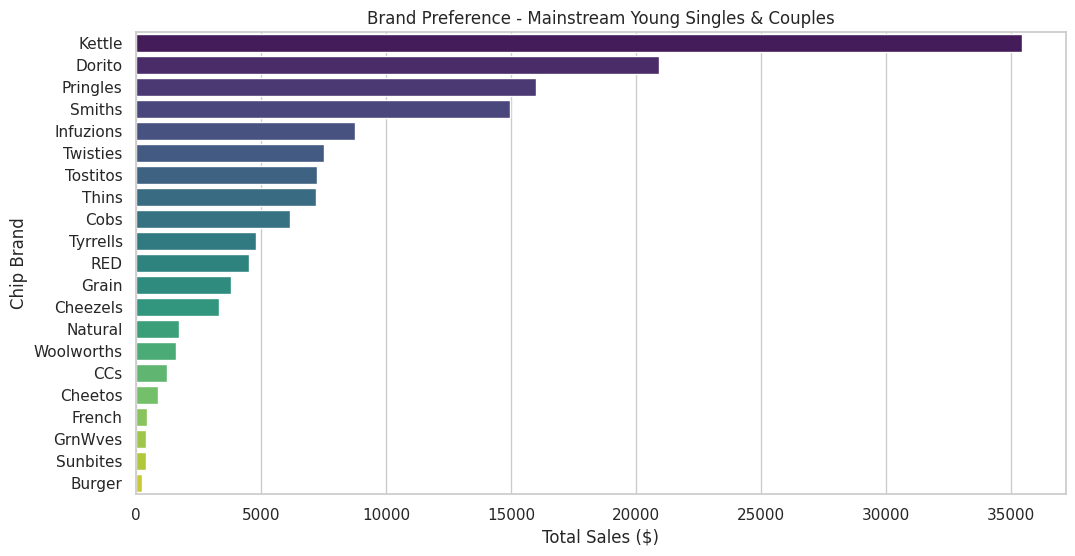

In [21]:
# Filter for Mainstream Young Singles/Couples
young_mainstream = merged_df[(merged_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &
                              (merged_df['PREMIUM_CUSTOMER'] == 'Mainstream')]

# Aggregate total sales by brand
brand_sales = young_mainstream.groupby('BRAND')['TOT_SALES'].sum().reset_index()

# Sort values for better visualization
brand_sales = brand_sales.sort_values(by='TOT_SALES', ascending=False)

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(data=brand_sales, x='TOT_SALES', y='BRAND', palette='viridis')
plt.xlabel('Total Sales ($)')
plt.ylabel('Chip Brand')
plt.title('Brand Preference - Mainstream Young Singles & Couples')
plt.show()


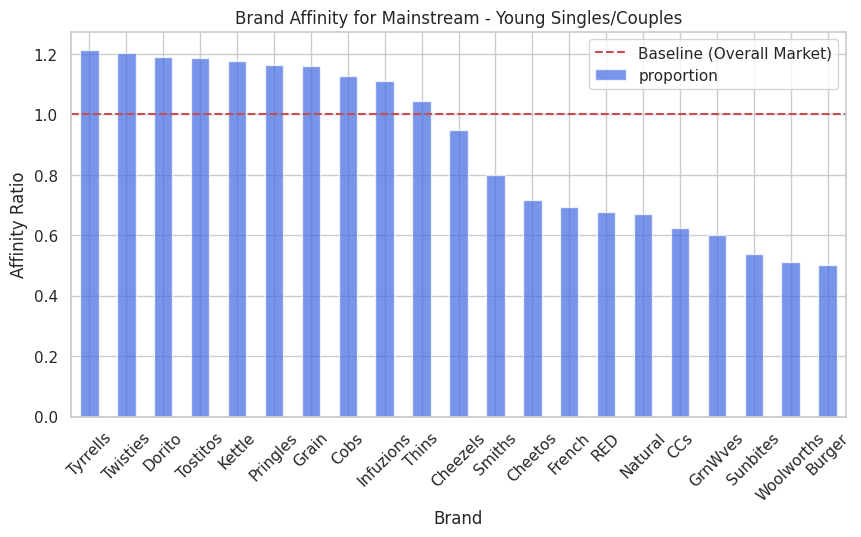

In [22]:
# Filter for 'Mainstream - Young Singles/Couples'
target_segment = merged_df[(merged_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &
                            (merged_df['PREMIUM_CUSTOMER'] == 'Mainstream')]

# Count purchases by brand for this segment
segment_brand_counts = target_segment['BRAND'].value_counts(normalize=True) * 100

# Count overall purchases by brand
overall_brand_counts = merged_df['BRAND'].value_counts(normalize=True) * 100

# Calculate brand affinity by comparing segment % to overall %
brand_affinity = (segment_brand_counts / overall_brand_counts).dropna().sort_values(ascending=False)

# Plot the brand affinity
plt.figure(figsize=(10, 5))
brand_affinity.plot(kind='bar', color='royalblue', alpha=0.7)
plt.axhline(y=1, color='r', linestyle='--', label="Baseline (Overall Market)")
plt.title('Brand Affinity for Mainstream - Young Singles/Couples')
plt.ylabel('Affinity Ratio')
plt.xlabel('Brand')
plt.legend()
plt.xticks(rotation=45)
plt.show()


<ipython-input-23-09291ec21923>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_price_by_brand, x='BRAND', y='UNIT_PRICE', palette='viridis')


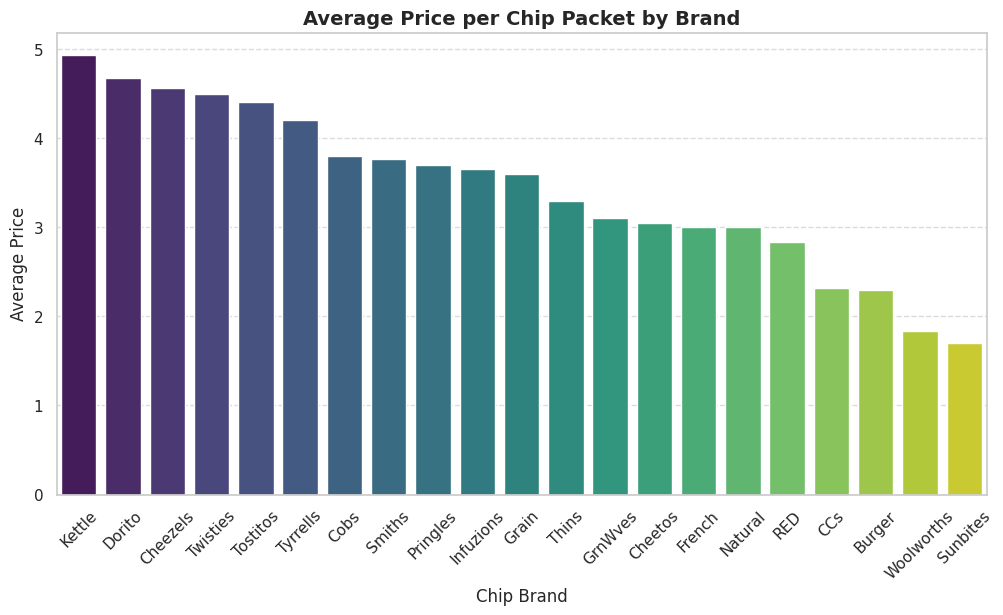

In [23]:
# prompt: Find the plot of average price vs chips catogories

# Assuming 'merged_df' is your DataFrame with the necessary columns
# Calculate the average price per chip packet
merged_df['UNIT_PRICE'] = merged_df['TOT_SALES'] / merged_df['PROD_QTY']

# Group by brand and calculate the average price
avg_price_by_brand = merged_df.groupby('BRAND')['UNIT_PRICE'].mean().reset_index()

# Sort by average price for better visualization
avg_price_by_brand = avg_price_by_brand.sort_values(by='UNIT_PRICE', ascending=False)

# Plot the average price vs. brand
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_price_by_brand, x='BRAND', y='UNIT_PRICE', palette='viridis')

# Formatting the plot
plt.xlabel("Chip Brand", fontsize=12)
plt.ylabel("Average Price", fontsize=12)
plt.title("Average Price per Chip Packet by Brand", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


Mainstream Young Singles & Couples are more likely to buy Tyrrells than other brands. And are less likely to buy Burger than other brands.

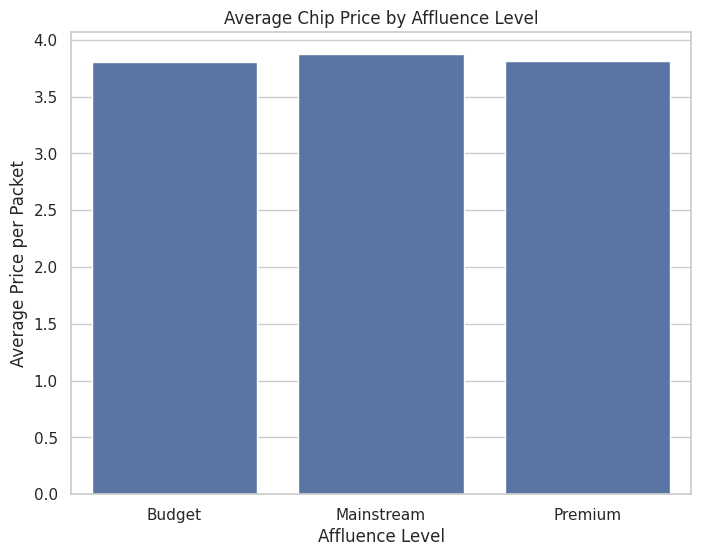

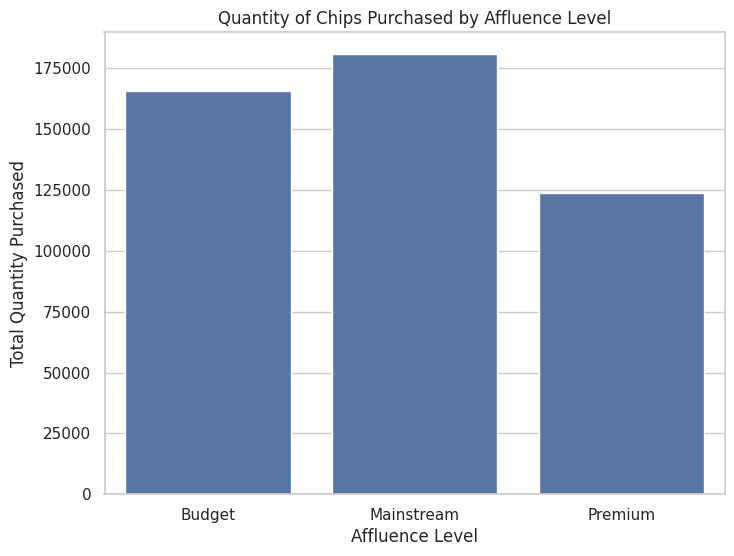

In [24]:
avg_price_by_affluence = merged_df.groupby('PREMIUM_CUSTOMER')['UNIT_PRICE'].mean().reset_index()

# Plot the results
plt.figure(figsize=(8, 6))
sns.barplot(x='PREMIUM_CUSTOMER', y='UNIT_PRICE', data=avg_price_by_affluence)
plt.xlabel('Affluence Level')
plt.ylabel('Average Price per Packet')
plt.title('Average Chip Price by Affluence Level')
plt.show()

# Example: Analyze the quantity of chips purchased by different affluence levels.
quantity_by_affluence = merged_df.groupby('PREMIUM_CUSTOMER')['PROD_QTY'].sum().reset_index()

# Plot the results
plt.figure(figsize=(8, 6))
sns.barplot(x='PREMIUM_CUSTOMER', y='PROD_QTY', data=quantity_by_affluence)
plt.xlabel('Affluence Level')
plt.ylabel('Total Quantity Purchased')
plt.title('Quantity of Chips Purchased by Affluence Level')
plt.show()


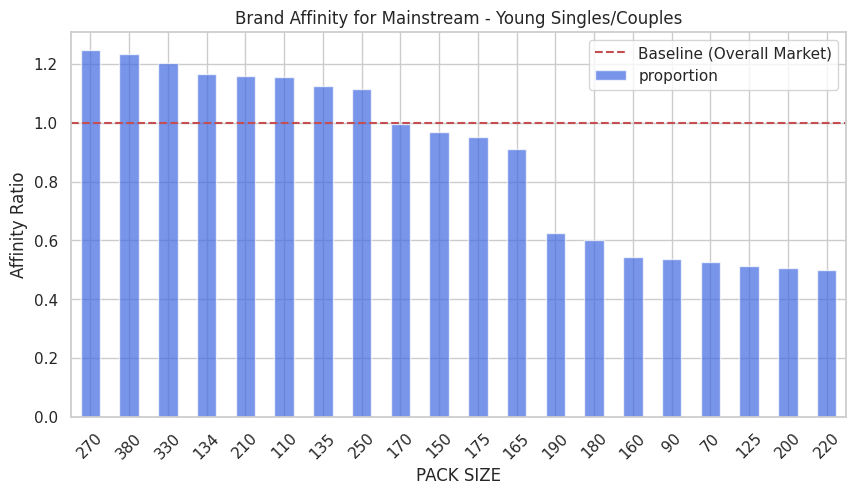

In [25]:
# Filter for 'Mainstream - Young Singles/Couples'
target_segment = merged_df[(merged_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &
                            (merged_df['PREMIUM_CUSTOMER'] == 'Mainstream')]

# Count purchases by brand for this segment
segment_brand_counts = target_segment['PACK_SIZE'].value_counts(normalize=True) * 100

# Count overall purchases by brand
overall_brand_counts = merged_df['PACK_SIZE'].value_counts(normalize=True) * 100

# Calculate brand affinity by comparing segment % to overall %
brand_affinity = (segment_brand_counts / overall_brand_counts).dropna().sort_values(ascending=False)

# Plot the brand affinity
plt.figure(figsize=(10, 5))
brand_affinity.plot(kind='bar', color='royalblue', alpha=0.7)
plt.axhline(y=1, color='r', linestyle='--', label="Baseline (Overall Market)")
plt.title('Brand Affinity for Mainstream - Young Singles/Couples')
plt.ylabel('Affinity Ratio')
plt.xlabel('PACK SIZE')
plt.legend()
plt.xticks(rotation=45)
plt.show()


It looks like Mainstream young singles/couples are 27% more likely to purchase a 270g pack of chips compared to the rest of the population.


In [26]:
pack_size_df = merged_df[merged_df['PACK_SIZE'] == 270]
pack_size_df['BRAND'].unique()

array(['Twisties'], dtype=object)

Twisties are the only brand offering 270g packs and so this may instead be reflecting a higher likelihood of purchasing Twisties.

<ipython-input-27-84889b4e6ee5>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x='LIFESTAGE', y='PACK_SIZE', palette='viridis')


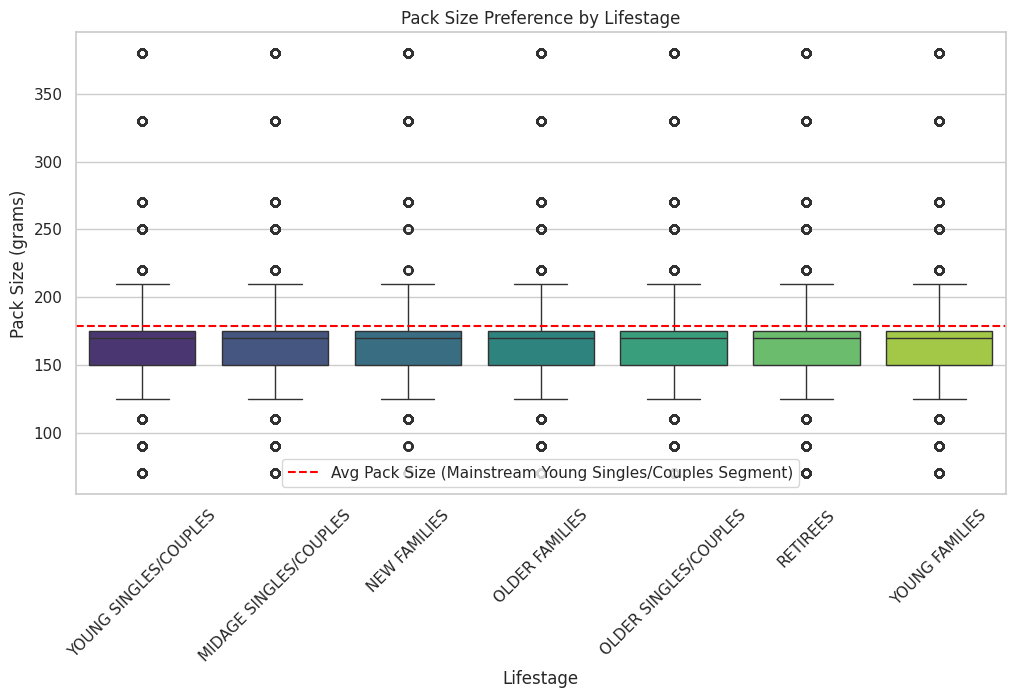

In [27]:
# Filter for Mainstream Young Singles/Couples
young_mainstream = merged_df[(merged_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &
                              (merged_df['PREMIUM_CUSTOMER'] == 'Mainstream')]

# Compare average pack size purchased
avg_pack_size = merged_df.groupby('LIFESTAGE')['PACK_SIZE'].mean().reset_index()

# Boxplot comparing pack size preference
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df, x='LIFESTAGE', y='PACK_SIZE', palette='viridis')
plt.axhline(young_mainstream['PACK_SIZE'].mean(), color='red', linestyle='--', label="Avg Pack Size (Mainstream Young Singles/Couples Segment)")
plt.xlabel('Lifestage')
plt.ylabel('Pack Size (grams)')
plt.title('Pack Size Preference by Lifestage')
plt.xticks(rotation=45)
plt.legend()
plt.show()


<ipython-input-28-59766163d48e>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='LIFESTAGE', y='TOT_SALES', hue='PREMIUM_CUSTOMER', data=merged_df, ci=None)


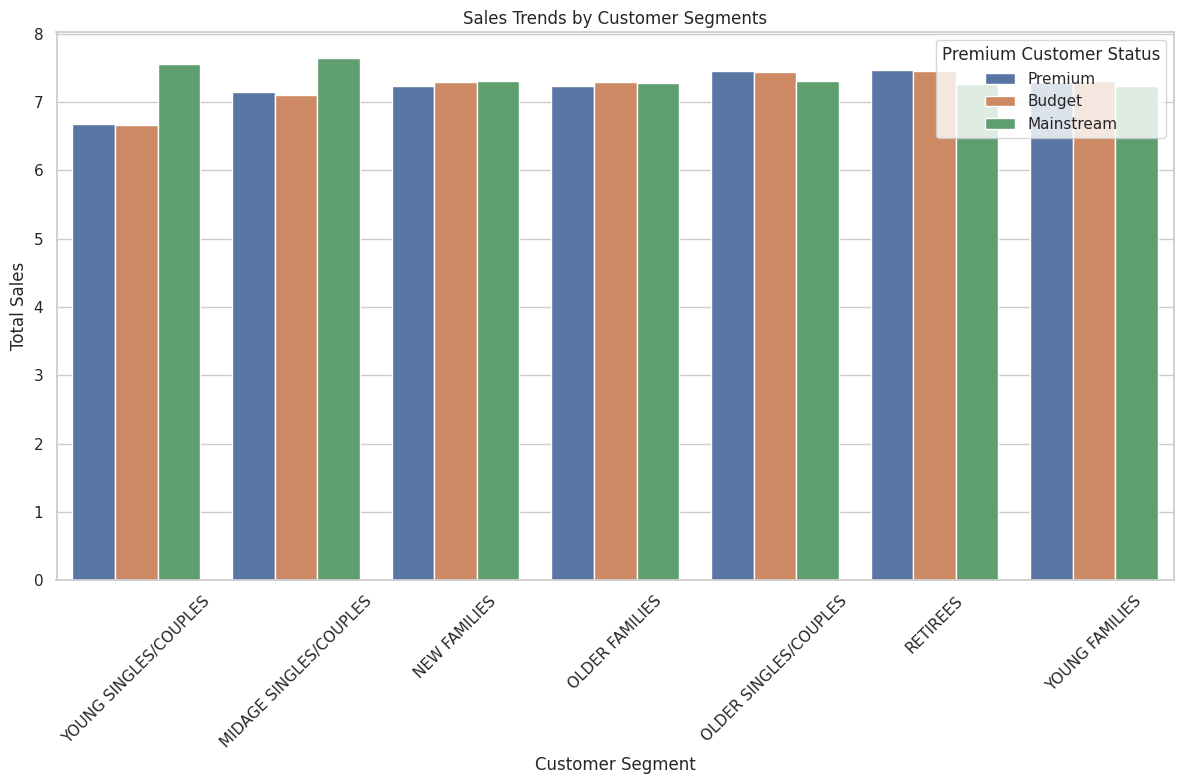

In [28]:
# 1. Sales Trends by Customer Segments (Bar Chart)
plt.figure(figsize=(12, 8))
sns.barplot(x='LIFESTAGE', y='TOT_SALES', hue='PREMIUM_CUSTOMER', data=merged_df, ci=None)
plt.title('Sales Trends by Customer Segments')
plt.xticks(rotation=45)
plt.xlabel('Customer Segment')
plt.ylabel('Total Sales')
plt.legend(title='Premium Customer Status')
plt.tight_layout()
